In [63]:
!pip install -U efficientnet

Requirement already up-to-date: efficientnet in /opt/conda/lib/python3.7/site-packages (1.1.0)


In [3]:
!pip install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-snx57nwn
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-snx57nwn
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=18397 sha256=dc8aa8ea24d03609fe152c9281dd2effc188770cc9b3a22084880d545a920897
  Stored in directory: /tmp/pip-ephem-wheel-cache-zk6ogb24/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [45]:
pip install keras==2.2.3


     |████████████████████████████████| 312 kB 8.7 MB/s eta 0:00:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.0.0
    Uninstalling Keras-2.0.0:
      Successfully uninstalled Keras-2.0.0
Note: you may need to restart the kernel to use updated packages.


In [84]:
import math, re, os

import numpy as np
import pandas as pd
from kaggle_datasets import KaggleDatasets
import tensorflow as tf

import tensorflow.keras.layers as L
import efficientnet.tfkeras as efn

from sklearn.model_selection import train_test_split
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [48]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path("alaska2-image-steganalysis")

# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IM_SIZE = 512

In [49]:
def append_path(pre):
    return np.vectorize(lambda file: os.path.join(GCS_DS_PATH, pre, file))

In [50]:
sub = pd.read_csv('/kaggle/input/alaska2-image-steganalysis/sample_submission.csv')
train_filenames = np.array(os.listdir("/kaggle/input/alaska2-image-steganalysis/Cover/"))

In [51]:
# np.random.seed(0)
positives = train_filenames.copy()
negatives = train_filenames.copy()
np.random.shuffle(positives)
np.random.shuffle(negatives)

jmipod = append_path('JMiPOD')(positives[:10000])
juniward = append_path('JUNIWARD')(positives[10000:20000])
uerd = append_path('UERD')(positives[20000:30000])

pos_paths = np.concatenate([jmipod, juniward, uerd])

In [52]:
test_paths = append_path('Test')(sub.Id.values)
neg_paths = append_path('Cover')(negatives[:30000])

In [53]:
train_paths = np.concatenate([pos_paths, neg_paths])
train_labels = np.array([1] * len(pos_paths) + [0] * len(neg_paths))

In [54]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_paths, train_labels, test_size=0.15)

gs://kds-d7606dbfd8ee47349bbbb9988a9e87859e3b3b51f73e9e96b81f109a/UERD/09756.jpg


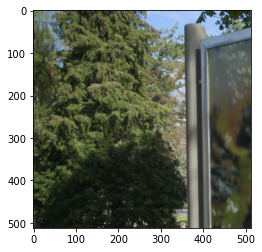

In [55]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

raw = tf.io.read_file("gs://kds-d7606dbfd8ee47349bbbb9988a9e87859e3b3b51f73e9e96b81f109a/UERD/00001.jpg")
print(train_paths[0])
image = tf.image.decode_jpeg(raw, channels = 3)

#plt.imshow(image)

image = tf.cast(image, tf.float32) / 255.0
#plt.imshow(image)


plt.imshow(img)

In [56]:
def decode_image(filename, label=None, image_size=(IM_SIZE, IM_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    image = tf.image.rgb_to_yuv(image)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label
    
    
def rgb_to_ycbcr(image, label = None):
    image = tf.image.rgb_to_yuv(image)
    
    if label is None:
        return image
    else:
        return image, label
    

In [57]:
train_labels[0]

1

In [58]:
train_image = []

#for i in range(len(train_paths)):
#    train_image.append(decode_image(train_paths[i], image_size = (512,512)))

In [59]:
train_image[0]

IndexError: list index out of range

In [61]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [80]:
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam
from keras import applications
from keras import callbacks
from keras.models import Sequential

efficient_net = efn.EfficientNetB2(weights='imagenet', include_top=False,
                                   input_shape= (512, 512, 3))


model = Sequential()
#model.add(efficient_net)
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

TypeError: The added layer must be an instance of class Layer. Found: <tensorflow.python.keras.layers.core.Dense object at 0x7f7d6431f6d0>

In [86]:
efficient_net = efn.EfficientNetB1(weights='imagenet', include_top=False,
                                   input_shape= (512, 512, 3), pooling = 'max')

In [87]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential




model1 = Sequential()
model1.add(efficient_net)

model1.add(Dense(units = 16, activation = 'relu'))
model1.add(Dense(units = 1, activation='sigmoid'))
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Model)      (None, 1280)              6575232   
_________________________________________________________________
dense_1 (Dense)              (None, 16)                20496     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 6,595,745
Trainable params: 6,533,697
Non-trainable params: 62,048
_________________________________________________________________


In [93]:
model1.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [88]:
EPOCH = 3
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

checkpoint = callbacks.ModelCheckpoint('model_b2.h5',monitor = 'val_loss', save_best_only = True, verbose = 1, period = 1)

reduceLR = callbacks.ReduceLROnPlateau(monitor = 'val_loss', min_lr = 0.00001, patience = 3, mode = 'min', verbose = 1)

In [89]:
#with strategy.scope():
#    model_efn = tf.keras.models.load_model('../input/alaska-tpu/model_b3.h5')

In [74]:
train_dataset.shuffle(200).batch(4).repeat()

<RepeatDataset shapes: ((None, None, 512, 512, 3), (None, None)), types: (tf.float32, tf.int64)>

In [ ]:
history = model1.fit(train_dataset, epochs = EPOCH, steps_per_epoch = STEPS_PER_EPOCH, validation_data = valid_dataset, callbacks = [checkpoint, reduceLR])

In [ ]:
with strategy.scope():
    model_res = tf.keras.models.load_model('../input/alaska-tpu/model_b7.h5')

In [ ]:
history = model_res.fit(train_dataset, epochs = EPOCHS, steps_per_epoch = STEPS_PER_EPOCH, validation_data = valid_dataset,
                 callbacks = [checkpoint, reduceLR])

In [ ]:
probs = (model_res.predict(test_dataset, verbose=1)\
         +model_efn.predict(test_dataset, verbose=1))/2

In [ ]:
sub.Label = probs
sub.to_csv('submission..csv', index=False)
sub.head()